I've been doing my university physics homework in SymPy and Jupyter for a little bit, and I thought I could share a little about the workflow I've developed for it. It might come useful for you.
<!--TEASER_END-->

Let's go through with an abridged example of plasma physics homework with that toolset, and then go over the tricks used as they come up. I'll put text that I'd put in the homework solution in quotes.

> ## For electrostatic electron waves in unmagnetized plasma, calculate the correction to the frequency due to the ion motion.

We'll set up our SymPy namespace first. We'll dump it all into the main namespace; not the best habit for libraries, but here we want to write less code, so it'll do.

In [1]:
%config InteractiveShell.ast_node_interactivity = 'last_expr_or_assign'
from sympy import *
init_printing()

I also added a little IPython magic in there. This is a little behavior I picked up from working in Julia, where **the value last expression or assignment in a cell is displayed**.

> We take the linearized forms in Fourier space of the following fluid equations:
> 1. equation of motion, for ions, with temperature
> 2. equation of motion, for electrons, with temperature
> 3. mass conservation for ions
> 4. mass conservation for electrons
> 5. Poisson's equation

Now, let's define our variables and the set of equations we care about. Note how we'll liberally use unicode characters to shorten our code. In Jupyter, you can enter $\omega$ in code cells by simply writing the LaTeX for it and hitting TAB afterwards: `\omega<TAB>`

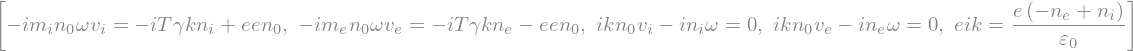

In [2]:
m_i, m_e, γ, T, n_0, e, ϵ = symbols('m_i m_e gamma T n_0 e varepsilon_0', positive=True)
ω, k = symbols('omega k', positive=True)
v_i, v_e, n_i, n_e = symbols('v_i v_e n_i n_e')  # to be understood as fourier modes

equations = [
    Eq(-I * ω * m_i * n_0 * v_i, +e * n_0 * E - I * k * γ * T * n_i),
    Eq(-I * ω * m_e * n_0 * v_e, -e * n_0 * E - I * k * γ * T * n_e),
    Eq(-I * ω * n_i + I * k * n_0 * v_i, 0),
    Eq(-I * ω * n_e + I * k * n_0 * v_e, 0),
    Eq(I * k * E , e * (n_i - n_e) / ϵ)
]

See? That's output right there. Neat! Anyway, 
> We first solve equations 3 and 4 for the velocities:

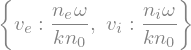

In [3]:
v_i_e_solutions = solve(equations[2:4], [v_i, v_e])

> We then insert the velocities into the equations of motion:

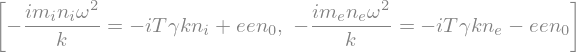

In [4]:
motion_equations = [eq.subs(v_i_e_solutions) for eq in equations[0:2]]

> From this, it is simple to grab the number densities:

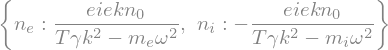

In [5]:
n_i_e_solutions = solve(motion_equations, (n_i, n_e))

> And now we can insert those back into the final, Poisson's equation:

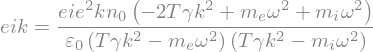

In [6]:
poisson_eq = equations[-1].subs(n_i_e_solutions).simplify()

> This we can solve for the $\omega^2$:

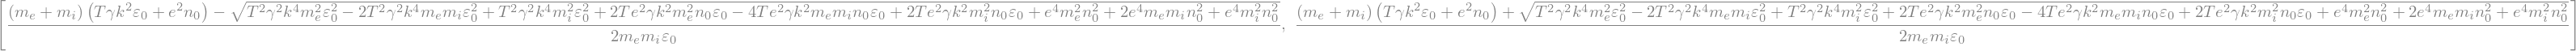

In [7]:
ω2_solutions = solve(poisson_eq, ω**2)

> Which is the complete analytical answer. as a sanity check, we can take the limit $m_i \to \infty$. Starting with the first one:

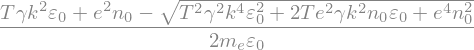

In [8]:
limit1 = limit(ω2_solutions[0], m_i, oo)

> Which, if we help SymPy a little (it didn't quite notice a pattern in the square root):

This is, unfortunately, a problem that SymPy tends to run into - this kind of issue needs some tinkering sometimes:

In [9]:
numerator, denominator = limit1.as_numer_denom()
sum(arg.factor() for arg in numerator.args) / denominator

> Which is not particularly interesting, corresponding to no oscillation at all. Applying the same procedure to the other solution:

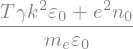

In [10]:
limit2 = limit(ω2_solutions[1], m_i, oo).simplify()
numerator, denominator = limit2.as_numer_denom()
limit2_corrected = (sum(arg.factor() for arg in numerator.args) / denominator).simplify()

> Which is the existing result for the electrostatic electron oscillation for warm electrons. Good! We're sane. Now, we have an analytic expression, but if we want to grab just the first order correction, we can apply some trickery.
> 
> Let's define
> 
> $$M = m_e / m_i$$
> 
> This is a small quantity, and we an expand our $\omega^2$ solutions in a power series in that.
> 
> We'll then replace $m_i$ in the second $\omega^2$ solution using $M$:

In [11]:
Mratio = symbols("M", positive=True)
series_expansion = (ω2_solutions[1]).subs(m_i, m_e / Mratio).expand().series(Mratio, n = 2);

Note how I'm using `;` at the end to stop this from displaying.

> We once again apply some SymPy magic to make the series expansion bearable for the eyes:

This took a bunch of StackOverflow searching, which, if you're on a deadline, may admittedly not be the most productive thing to do:

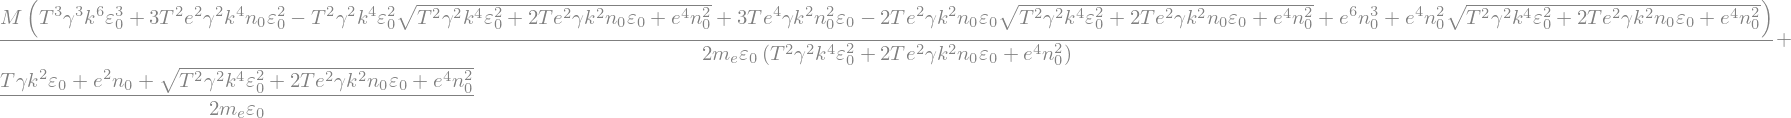

In [12]:
simplified_series_expansion = collect(series_expansion.removeO(), Mratio, simplify);

> Applying some further simplification for the square root:

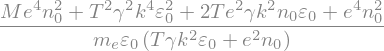

In [13]:
squareroot = numer(simplified_series_expansion.args[0]).args[0]
very_simplified_series_expansion = simplified_series_expansion.subs(squareroot, squareroot.factor()).simplify()

> And we arrive at the known and expected first order (in $m_e/m_i$) correction, substituting our definition of $M$ back in here:

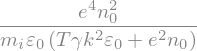

In [14]:
ion_correction = (very_simplified_series_expansion - limit2_corrected).simplify().subs(Mratio, m_e / m_i)

And that's that!

# Results and thoughts

For some pros and cons:

## Positives

* You get to skip out on algebraic errors.
* You get beautiful LaTeX display, at no effort, for each step. This helps a ton if your handwriting is dreadful, like mine is.
* You can resort to first-order corrections etc if you need a check, but you actually get full analytical solutions a lot of the time.

## Neutrals

* You really need to watch your assumptions when you define your variables, as SymPy is pretty conservative with its simplifications. This is, of course, both a blessing and a curse.
* The learning curve is a bit steep, but you can accomplish plenty with just a little knowledge; for the rest, you can google. I've been putting off picking up its `physics` subpackage for way too long now.

## Negatives

* There are kinks, as you undoubtedly saw; it can be tough to tell SymPy "look at that square root! Look at it!". It'll miss some seemingly obvious stuff, and it can take a fair bit of googling to get it to work properly.
* Runtimes can get steep-ish; it's not really suited for live work. I'll `%timeit` the two lines that caused a little trouble here. Admittedly, symbolic math is *hard*, so I'm not too surprised. ~~Turns out I could only timeit the first line in reasonable time...~~

In [15]:
%timeit series_expansion = (ω2_solutions[1]).subs(m_i, m_e / Mratio).expand().series(Mratio, n = 2);

24.3 s ± 351 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Still, all in all, I think it has plenty of potential. If it's not there *yet*, it's getting there! I'm likely to keep using it and if I come up with any further handy tools, I'll get back here.